
<h2 align=center>Keras for Anomaly Detection in Time Series</h2>


This code builds an anomaly detection model for time series data using deep learning. Specifically we build a LSTM autoencoder on Keras with Tensorflow 2 as back end. 

## Import Libraries


 

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None  # suppressing all warnings
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.3.1


## Load and Inspect the S&P 500 Index Data

S&P 500 is one of the largest stock market indices in the US, and will be used as the dataset. 


[Data Source](https://www.kaggle.com/pdquant/sp500-daily-19862018): S&P500 Daily Prices 1986 - 2018

In [2]:
df = pd.read_csv('S&P_500_Index_Data.csv', parse_dates=['date'])
df.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [3]:
# Checking on the shape of the data. 
df.shape

(8192, 2)

In [4]:
# Visualization of the time series. 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.close,
                    mode='lines',
                    name='close'))
fig.update_layout(showlegend=True)
fig.show()

## Data Preprocessing




In [5]:
# Defining the size of the subsets (train and test). 

train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

# Create the subsets using the indices. 
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [6]:
from sklearn.preprocessing import StandardScaler

# Standardization: Remove the mean and scale the data to the unit variance using Scikit-learn's StandardScaler. 

scaler = StandardScaler()
scaler = scaler.fit(train[['close']]) # fitting the scaler 

# transforming both train and test set with the learnt parameters
train['close'] = scaler.transform(train[['close']]) 
test['close'] = scaler.transform(test[['close']])

## Create Training and Test Splits

Data must be reshaped as required by the LSTM algorithm, that being: 

(number of samples, number of time steps, number of features)



In [7]:


def create_dataset(X, y, time_steps=1):
    """
    Function to facilitate reusability of the code. 
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
time_steps = 30

X_train, y_train = create_dataset(train[['close']], train.close, time_steps)
X_test, y_test = create_dataset(test[['close']], test.close, time_steps)

print(X_train.shape)

(6523, 30, 1)


## Build an LSTM Autoencoder

1) Train an Autoencoder with data that has no anomalies. 

2) Take a new data point and try to reconstruct it with the Autoencoder. 

3) Evaluate the reconstruction error for the new data point. If it is above a threshold it will be classified as anomalous. 


In [9]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),   # just one LSTM layer with many cells as time steps
    Dropout(0.16),
    RepeatVector(timesteps),   # replicating the feature vectors from the output LSTM layer "timesteps" times. (ie. 30). Bridge between the encoder and the decoder modules. 
    LSTM(128, return_sequences=True),  # decoder. 
    Dropout(0.16),
    TimeDistributed(Dense(num_features))  # to get the output in the correct shape: a vector of length "num_features".                
])

model.compile(loss='mae', optimizer='adam')

# The network architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

## Training the Autoencoder

In [23]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='min')  # create a callback monitoring the validation loss. 
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks = [es],
    shuffle=False   # time series data mustn't be shuffled as the order matters. 
)

Epoch 1/100
184/184 [==============================] - 10s 53ms/step - loss: 0.1489 - val_loss: 0.1931
Epoch 2/100
184/184 [==============================] - 10s 53ms/step - loss: 0.1081 - val_loss: 0.1075
Epoch 3/100
184/184 [==============================] - 11s 58ms/step - loss: 0.0850 - val_loss: 0.1226
Epoch 4/100
184/184 [==============================] - 11s 61ms/step - loss: 0.0815 - val_loss: 0.0701
Epoch 5/100
184/184 [==============================] - 12s 63ms/step - loss: 0.0736 - val_loss: 0.0386
Epoch 6/100
184/184 [==============================] - 11s 62ms/step - loss: 0.0649 - val_loss: 0.0363
Epoch 7/100
184/184 [==============================] - 12s 63ms/step - loss: 0.0658 - val_loss: 0.0362
Epoch 8/100
184/184 [==============================] - 12s 63ms/step - loss: 0.0650 - val_loss: 0.0626
Epoch 9/100
184/184 [==============================] - 12s 68ms/step - loss: 0.0692 - val_loss: 0.0516
Epoch 10/100
184/184 [==============================] - 16s 85ms/step - l

## Plot Metrics and Evaluation of the Model

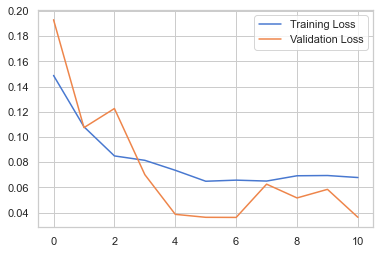

In [24]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [25]:

X_train_pred = model.predict(X_train)

# Calculating the MAE
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [26]:
model.evaluate(X_test, y_test)

51/51 [==============================] - 1s 17ms/step - loss: 0.2853


0.2852746546268463

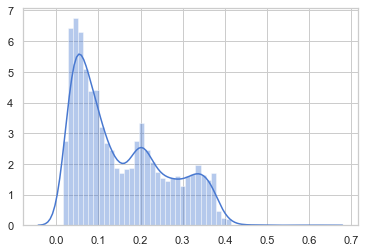

In [27]:
# Check on the distribution of the training error in order to define a threshold for what is anomalous. A value above which is unlikely to occur in training data. 
sns.distplot(train_mae_loss, bins=50, kde=True);

In [28]:
X_test_pred = model.predict(X_test)
 
# DF to store the loss for the test data 
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

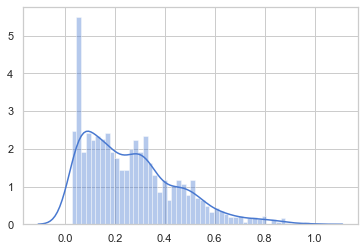

In [29]:
sns.distplot(test_mae_loss, bins=50, kde=True);

## Detecting Anomalies in Data

In [30]:
THRESHOLD = 0.55 # defined by inspection of the loss distribution in test data. 

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [31]:
# This line signals the data points where reconstruction error excedes that of the established threshold. 

fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [32]:
# Creating a new DF with the anomaly feature that signals the values that have error above the previously defined threshold. 

anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly
7474,2015-08-25,2.457439,0.610000,0.55,True
7475,2015-08-26,2.632149,0.682877,0.55,True
7476,2015-08-27,2.745147,0.606489,0.55,True
7975,2017-08-21,3.801338,0.567183,0.55,True
7976,2017-08-22,3.859192,0.572565,0.55,True


In [33]:
# Visualization of data with the anomalies highlighted. The scale is reversed. 

fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=scaler.inverse_transform(test[time_steps:].close),
                    mode='lines',
                    name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close),
                    mode='markers',
                    name='Anomalous'))
fig.update_layout(showlegend=True)
fig.show()